# LTSM Model

# Load the Data* and Make Transformations

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from vis_seaborn import VisSeaborn


file_handler = FileHandler()
sn = VisSeaborn()

In [31]:
WINDOW_SIZE = 48
train_df = file_handler.read_csv("../data/train.csv")

2022-05-27 13:12:02,106 — DfHelper — DEBUG — file read as csv


In [32]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(len(series)).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [33]:
sales_data = train_df.groupby("Date").agg({"Sales": "mean"})[:100].copy()

In [34]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(sales_data)
sales_data['DataScaled'] = scaled_array
BATCH_SIZE = len(sales_data) - (WINDOW_SIZE * 2)

In [39]:
model = tf.keras.models.load_model("../models/TimeSeriesModel-Customers-2022-05-26-19:43")

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_3 (LSTM)               (None, 10)                1240      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [41]:
Forecast = model_forecast(model, sales_data.DataScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE - WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1, 1))

1/1 [==============================] - 1s 620ms/step


In [42]:
prediction_df = sales_data[BATCH_SIZE - WINDOW_SIZE:-1]
prediction_df["Forecast"] = Results1
prediction_df[["Forecast", "Sales"]]

/tmp/ipykernel_7660/1298157758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df["Forecast"] = Results1


,Forecast,Sales
Date,,
2013-02-26,5145.353516,5070.483408
2013-02-27,5058.424316,5368.065471
2013-02-28,4843.994141,6333.143498
2013-03-01,4293.149414,6449.533632
2013-03-02,630.706665,6005.926457
2013-03-03,8779.823242,155.785650
2013-03-04,7761.816406,9562.370404
2013-03-05,7526.687012,7889.118386
2013-03-06,7192.722656,7162.545291


#  Descriptive Statistics and Visualizations of the Data.

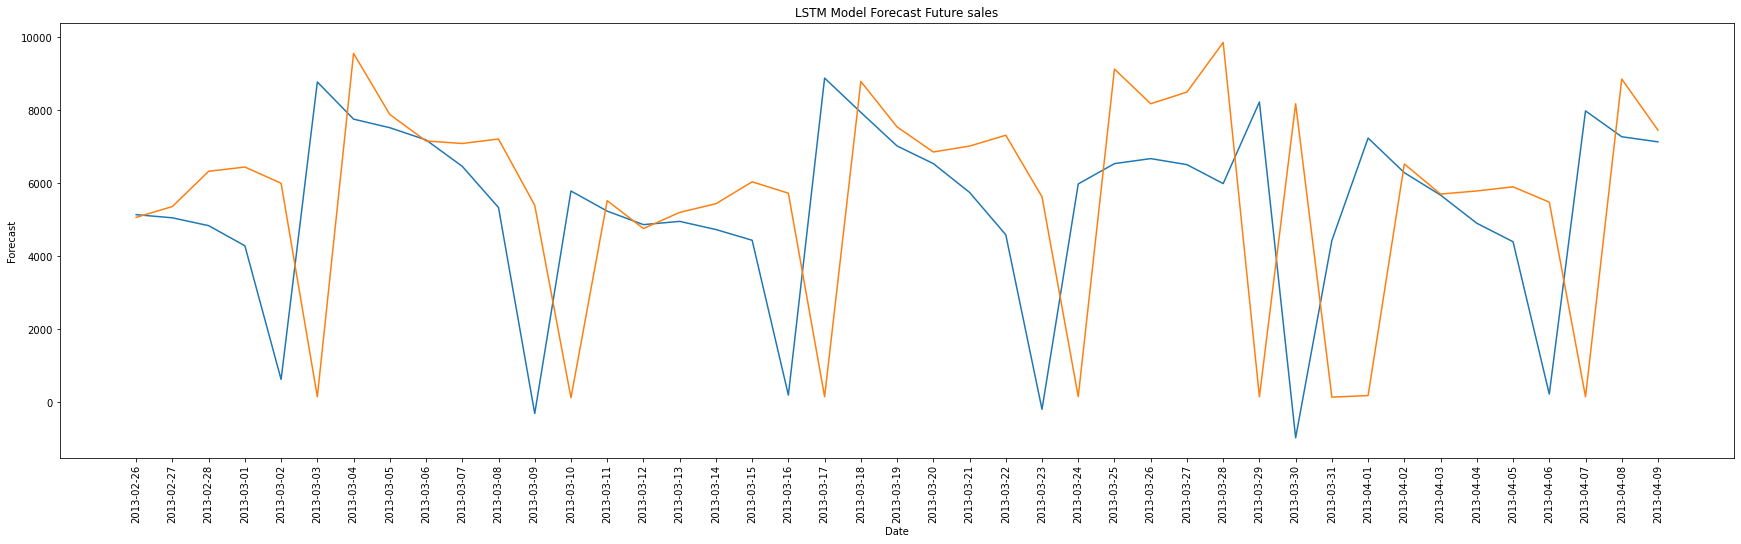

In [44]:
import seaborn as sns
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Future sales")
sns.lineplot(x=prediction_df.index, y=prediction_df["Forecast"])
sns.lineplot(x=prediction_df.index, y=prediction_df["Sales"])
plt.xticks(rotation=90)
plt.show()